In [6]:
from SnackTrackDataset import SnackTrackDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil
import random
from SnackTrackBasicModel import BasicModel

In [4]:
# prepare dataset with participant split
# Load metadata (example dataframe)
metadata_file = "/Users/jannisdaiber/Documents/Repos/github/ProjectMedicalWearables/Database/metadata.csv"  # Path to metadata file
metadata = pd.read_csv(metadata_file)

# Group by participant
participants = metadata['participant'].unique()

# Select one participant for validation
val_participant = random.choice(participants)  # Randomly select one participant
train_participants = [p for p in participants if p != val_participant]

# Create metadata subsets
train_metadata = metadata[metadata['participant'].isin(train_participants)]
val_metadata = metadata[metadata['participant'] == val_participant]

# Create datasets
train_dataset = SnackTrackDataset(train_metadata)
val_dataset = SnackTrackDataset(val_metadata)

train_size = len(train_dataset)
val_size = len(val_dataset)

print(f"Validation participant: {val_participant}")
print(f"Training participants: {train_participants}")

Validation participant: participant04
Training participants: ['participant02', 'participant05', 'participant03', 'participant01']


In [9]:
# prepare dataset with random split
# Dataset and DataLoader
metadata_file = "/Users/jannisdaiber/Documents/Repos/github/ProjectMedicalWearables/Database/metadata_balanced.csv"  # Path to metadata file
metadata = pd.read_csv(metadata_file)
dataset = SnackTrackDataset(metadata)

# Split into train and validation sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [7]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

MPS not available because the current PyTorch install was not built with MPS enabled.


In [10]:
# Parameters
batch_size = 16
learning_rate = 0.001
num_epochs = 4

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Initialize model, loss, optimizer
model = BasicModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

val_predictions = []
val_gt = []

for epoch in range(num_epochs):
    # perform training followed by validation
    for mode, loader, num_samples in [
        ("train", train_loader, train_size),
        ("val", val_loader, val_size)
    ]:
        # progress bar setup
        num_batches = int(ceil(num_samples / batch_size))
        pbar = tqdm(total=num_batches, desc=f"{mode} epoch {epoch}")

        if mode == "train":
            model.train()
        else:
            model.eval()

        # initial values of the metrics (loss, accurracy)
        runningLoss = 0.
        correct_predictions = 0
        # total number of images that were processed
        total_samples = 0

        for spectrograms, labels in loader:
            # move tensors to the correct device
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            # forward step of model
            outputs = model(spectrograms)

            if mode == "val":
                val_predictions.append(outputs.argmax(dim=1))
                val_gt.append(labels)

            # loss calculation
            loss = criterion(outputs, labels)

            # calculate metrix for progress bar
            num_batch_samples = len(spectrograms)
            runningLoss += loss.item()
            correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()
            total_samples += num_batch_samples

            pbar.update(1)
            pbar.set_postfix({
                "loss": runningLoss / total_samples,
                "accuracy": correct_predictions / total_samples
            })
            
            # if in train mode update weights
            if mode == "train":
                # backward step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
        epoch_loss = runningLoss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        if mode == "train":
            train_losses.append(epoch_loss)
            train_accuracy.append(epoch_accuracy)
        else:
            val_losses.append(epoch_loss)
            val_accuracy.append(epoch_accuracy)

        pbar.close()

Using device: cpu


val epoch 3: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s, loss=0.0136, accuracy=0.936] 


In [11]:
val_gt_list = [tensor.tolist() for tensor in val_gt]
val_predictions_list = [[int(item) for item in tensor.tolist()] for tensor in val_predictions]

True Positives: {0: 1060, 1: 1145, 2: 1188, 3: 1074}
False Positives: {0: 137, 1: 165, 2: 5, 3: 10}
True Negatives: {0: 3487, 1: 3415, 2: 3579, 3: 3554}
False Negatives: {0: 100, 1: 59, 2: 12, 3: 146}


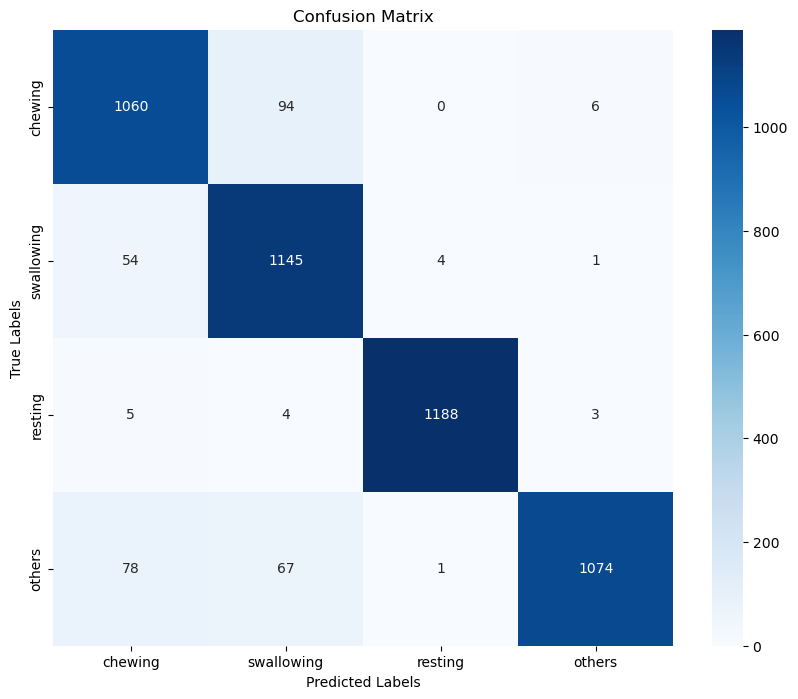

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Flatten the lists of tensors
val_predictions_flat = [item for sublist in val_predictions_list for item in sublist]
val_gt_flat = [item for sublist in val_gt for item in sublist]

# Convert to numpy arrays for easier manipulation
val_predictions_flat = np.array(val_predictions_flat)
val_gt_flat = np.array(val_gt_flat)

# Get the unique classes
classes = np.unique(val_gt_flat)

# Initialize dictionaries to store TP and FP for each class
tp = {cls: 0 for cls in classes}
fp = {cls: 0 for cls in classes}

# Calculate TP and FP for each class
for cls in classes:
    tp[cls] = np.sum((val_predictions_flat == cls) & (val_gt_flat == cls))
    fp[cls] = np.sum((val_predictions_flat == cls) & (val_gt_flat != cls))

print("True Positives:", tp)
print("False Positives:", fp)

# Initialize dictionaries to store TN and FN for each class
tn = {cls: 0 for cls in classes}
fn = {cls: 0 for cls in classes}

# Calculate TN and FN for each class
for cls in classes:
    tn[cls] = np.sum((val_predictions_flat != cls) & (val_gt_flat != cls))
    fn[cls] = np.sum((val_predictions_flat != cls) & (val_gt_flat == cls))

print("True Negatives:", tn)
print("False Negatives:", fn)

# Compute confusion matrix
cm = confusion_matrix(val_gt_flat, val_predictions_flat, labels=classes)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['chewing', 'swallowing', 'resting', 'others'], yticklabels=['chewing', 'swallowing', 'resting', 'others'], ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()

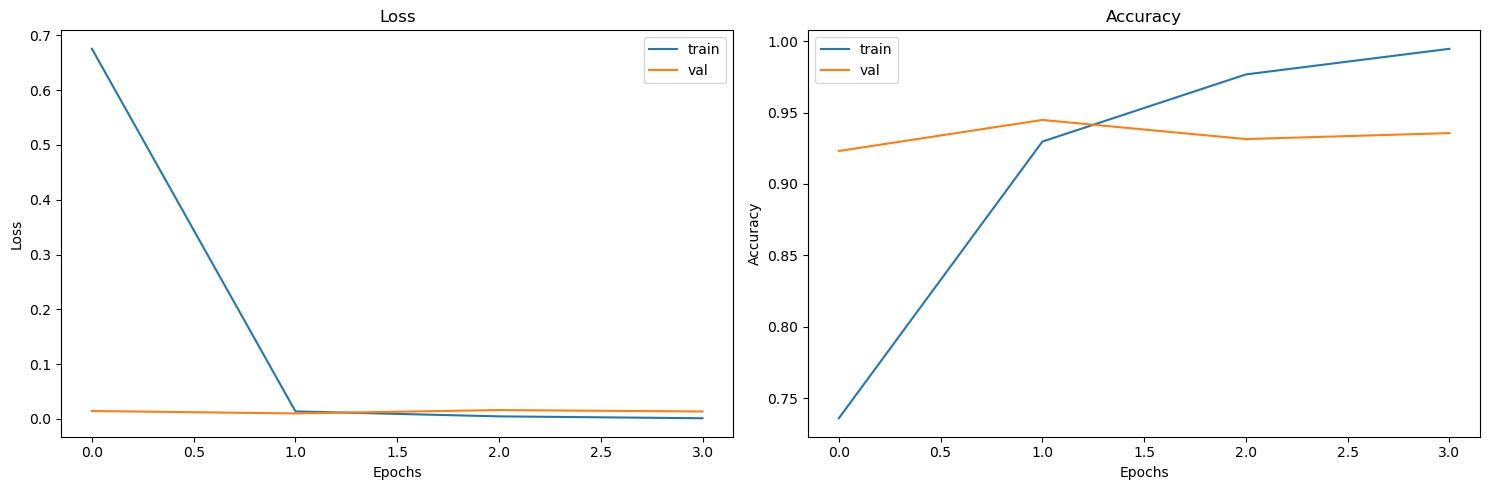

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].set_title("Loss")
axes[0].plot(train_losses, label="train")
axes[0].plot(val_losses, label="val")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot accuracy
axes[1].set_title("Accuracy")
axes[1].plot(train_accuracy, label="train")
axes[1].plot(val_accuracy, label="val")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

In [32]:
torch.save(model.state_dict(), 'STBasicModel.pth')